In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Import custom modules
from data_cleaning import FraudDataCleaner
from eda import FraudEDA
from geolocation import IPGeolocationMapper
from feature_engineering import FraudFeatureEngineer
from data_transformation import FraudDataTransformer

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Step 1: Load and Clean Data
print("="*80)
print("STEP 1: DATA LOADING AND CLEANING")
print("="*80)

# Initialize cleaner
cleaner = FraudDataCleaner(verbose=True)

# Load fraud data
fraud_data_path = r'C:\Users\admin\fraud-detection-week5\data\raw\creditcard.csv'
df_fraud = cleaner.load_data(fraud_data_path)

# Display initial info
print(f"\n📊 Dataset Information:")
print(f"Shape: {df_fraud.shape}")
print(f"Columns: {df_fraud.columns.tolist()}")
print(f"\nSample data:")
print(df_fraud.head())

# Comprehensive cleaning
df_fraud_clean = cleaner.clean_fraud_data(df_fraud)

# Generate cleaning report
cleaning_report = cleaner.generate_cleaning_report()

STEP 1: DATA LOADING AND CLEANING
✓ Dataset loaded: 10,000 rows, 11 columns
✓ Memory usage: 0.84 MB

📊 Dataset Information:
Shape: (10000, 11)
Columns: ['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'Class']

Sample data:
         V0        V1        V2        V3        V4        V5        V6  \
0  1.195860  0.357385 -0.665862 -0.492845 -0.863395 -0.050796 -1.933989   
1  0.825314  1.109459 -0.323136 -1.419545 -1.593368  1.107295  1.243526   
2 -0.906713 -0.593314  0.710714 -1.255291 -0.850725 -0.317640  1.499045   
3  1.200848 -1.306530 -0.496291 -1.858754 -2.127356 -0.879635 -0.393494   
4 -1.204798  0.078464  0.705181  0.224765  0.618707  1.534946 -0.302288   

         V7        V8        V9  Class  
0  2.081684  0.041266 -0.258298      0  
1 -0.172200  1.150359  0.147744      0  
2  0.434477  0.423678  1.251380      0  
3 -0.101213 -1.624066  0.443553      0  
4  2.325055  0.495505  0.538133      0  

COMPREHENSIVE DATA CLEANING - FRAUD DATASET

MISSING VALUES ANALYS


STEP 2: EXPLORATORY DATA ANALYSIS (EDA)


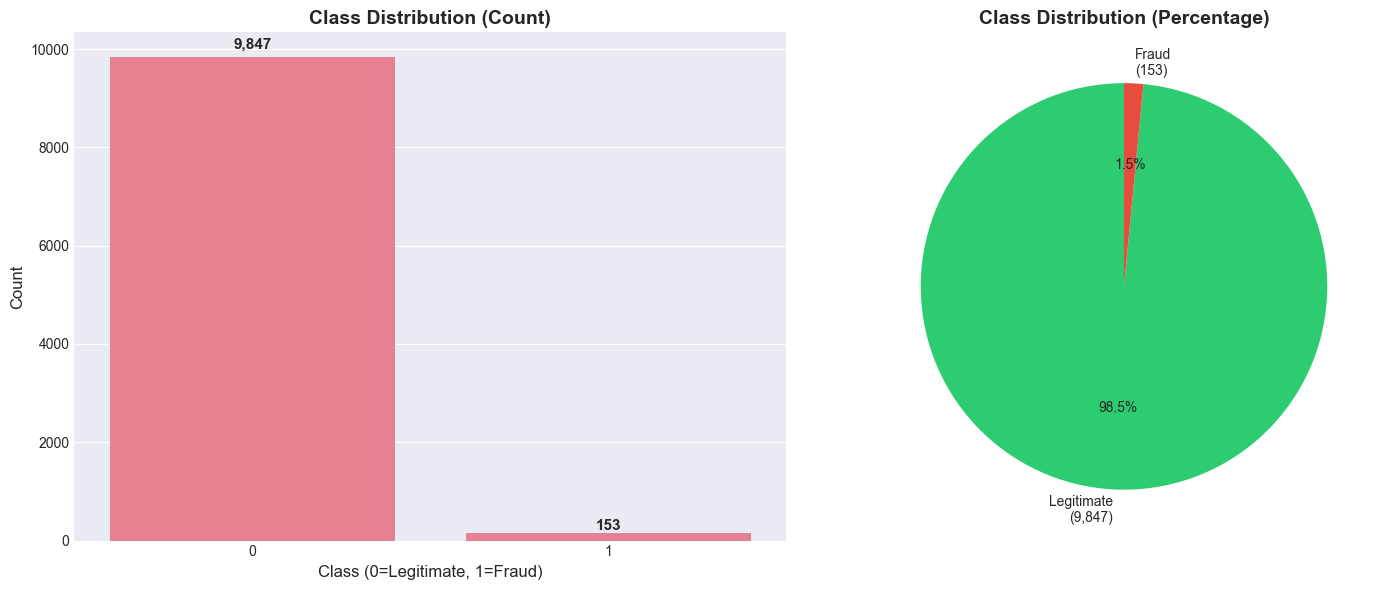


CLASS DISTRIBUTION ANALYSIS
Total samples: 10,000
Legitimate transactions: 9,847 (98.47%)
Fraudulent transactions: 153 (1.53%)
Imbalance ratio: 64.36:1
Fraud rate: 1.5300%

UNIVARIATE ANALYSIS

📊 NUMERICAL FEATURES (11):
         count   mean    std    min    50%    max  skewness  kurtosis
V0     10000.0  0.002  1.268 -4.635  0.631  3.152    -0.805    -0.418
V1     10000.0  0.004  1.006 -4.463  0.006  3.692    -0.016     0.070
V2     10000.0  0.123  0.764 -1.597 -0.191  2.843     0.713    -0.534
V3     10000.0 -0.987  0.950 -5.049 -1.001  3.853     0.095     1.399
V4     10000.0 -0.913  1.033 -5.158 -1.097  4.413     0.758     1.468
V5     10000.0  0.015  1.000 -3.533  0.024  3.728    -0.001    -0.023
V6     10000.0 -0.003  1.004 -4.295  0.003  3.606    -0.021    -0.044
V7     10000.0 -0.002  0.992 -3.726 -0.006  3.760     0.020    -0.064
V8     10000.0 -0.013  1.003 -4.466 -0.010  3.335     0.002    -0.060
V9     10000.0 -0.003  1.001 -4.158  0.002  3.536    -0.035    -0.047
Class  1

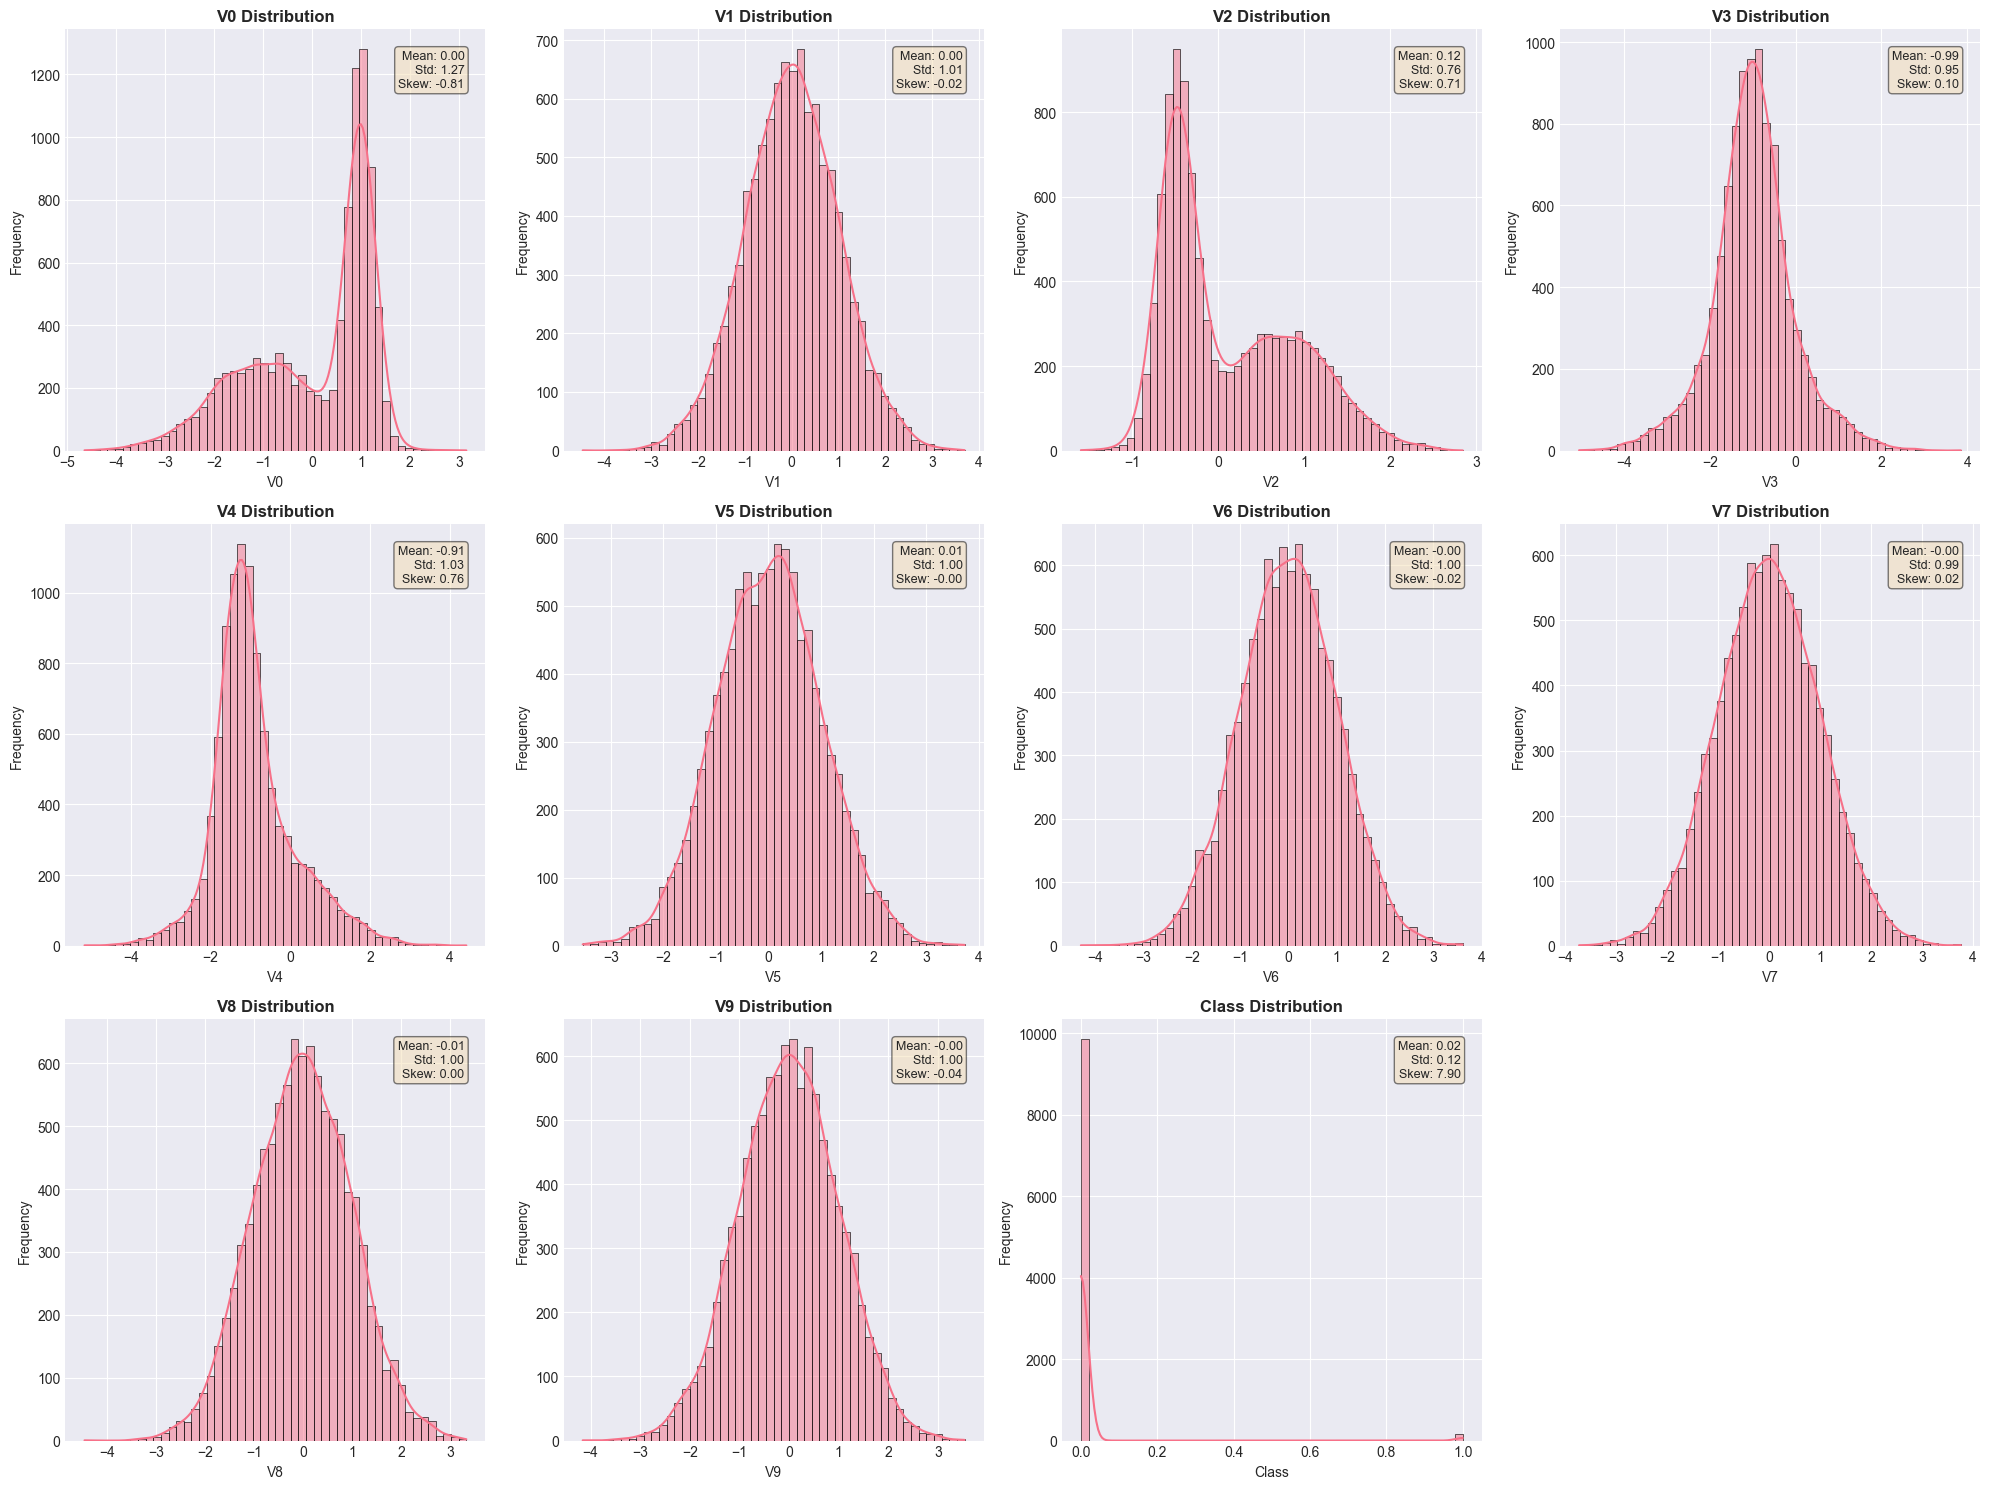


BIVARIATE ANALYSIS WITH TARGET

📈 NUMERICAL FEATURES vs TARGET (10 features):


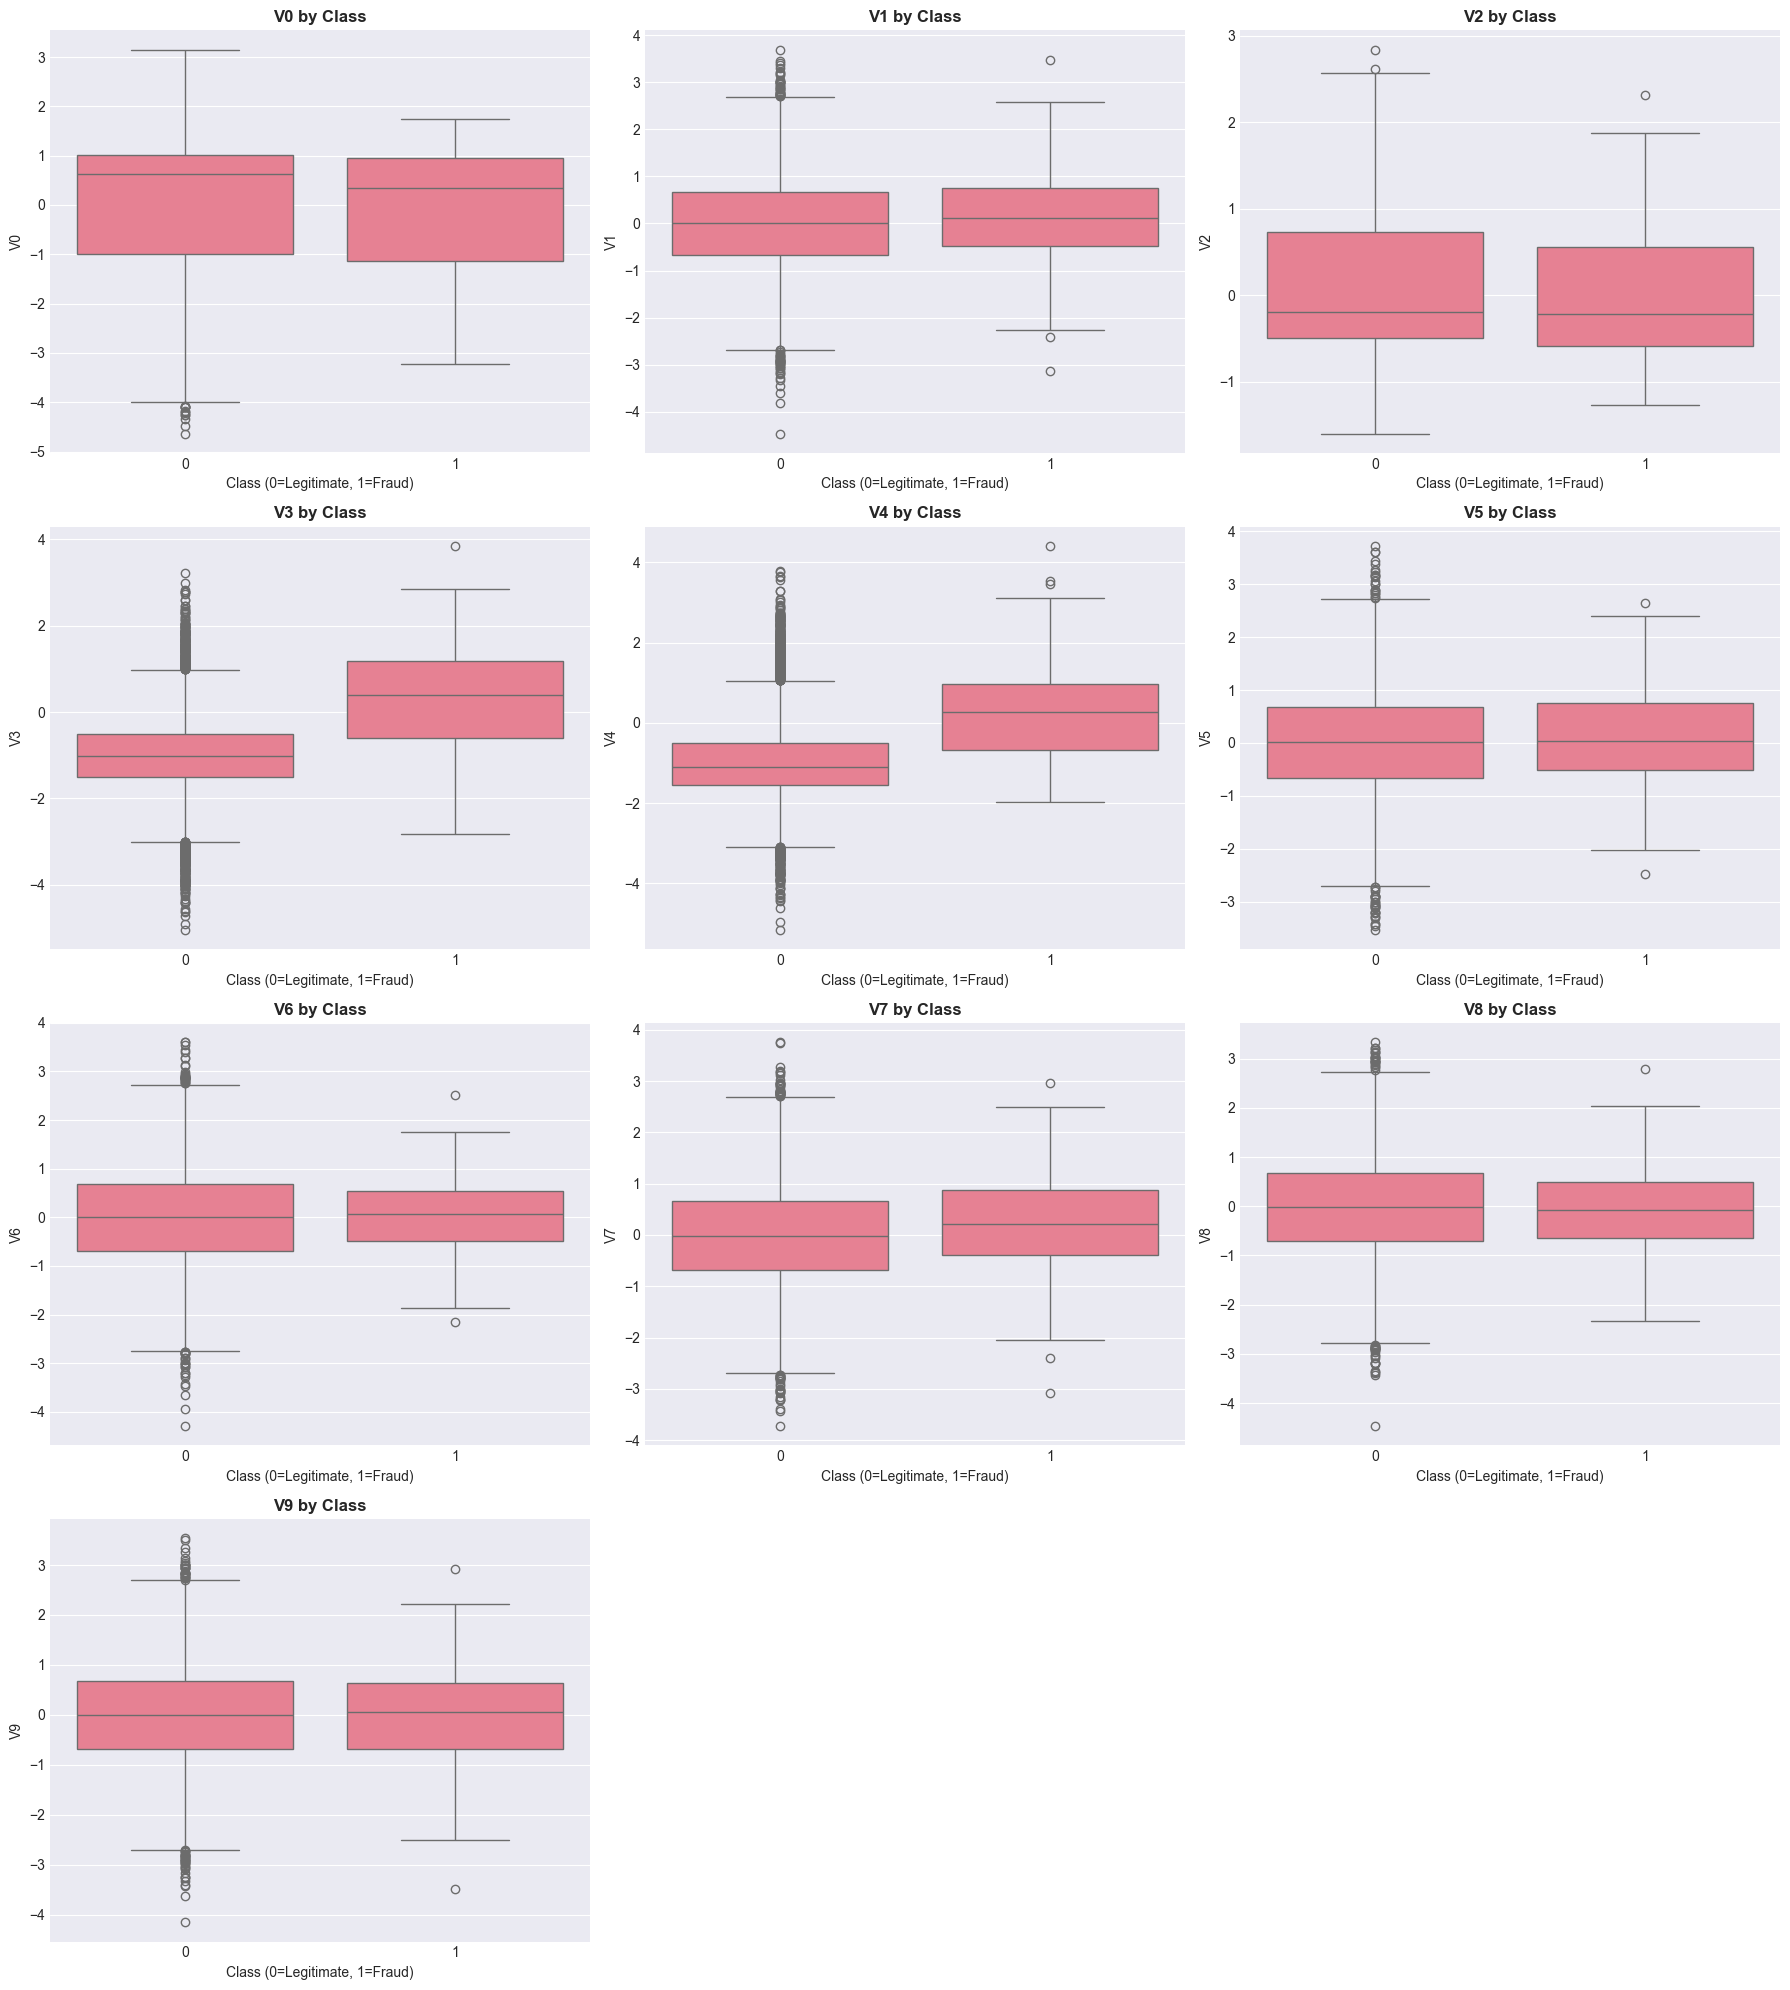


📊 CORRELATION WITH TARGET:
    correlation
V3       0.1643
V4       0.1441
V7       0.0289
V2      -0.0151
V1       0.0133
V5       0.0125
V0      -0.0106
V8      -0.0105
V9      -0.0023
V6       0.0022

CORRELATION ANALYSIS


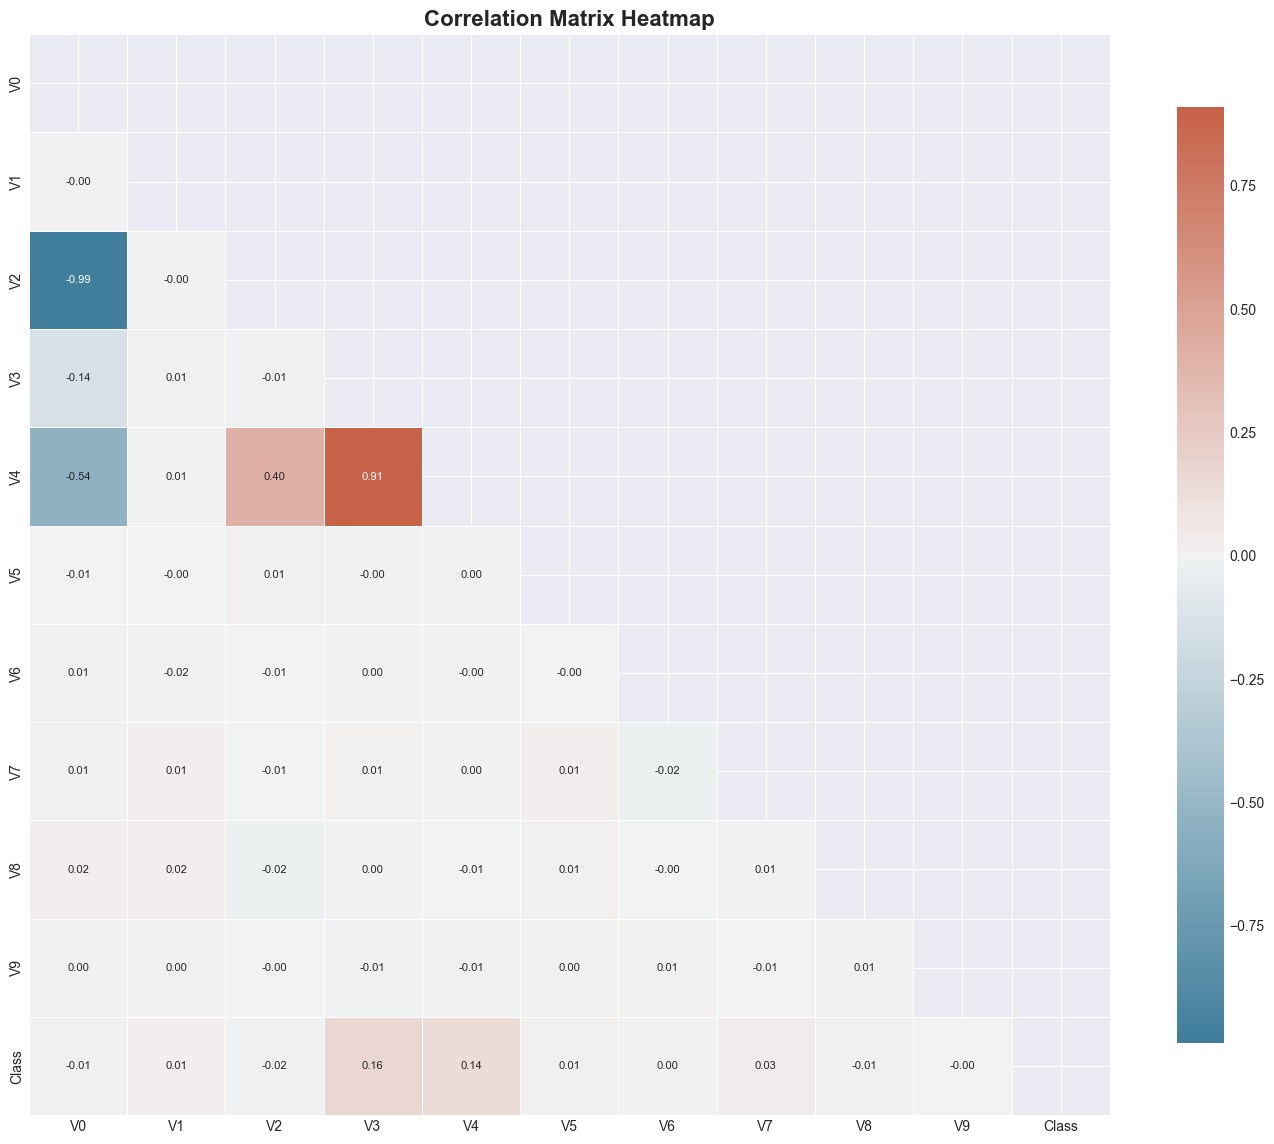


🔍 HIGHLY CORRELATED FEATURES (|correlation| > 0.8):
  V0 ↔ V2: -0.988
  V3 ↔ V4: 0.910

⚠️  WARNING: Highly correlated features detected
   Consider feature selection or dimensionality reduction

OUTLIER ANALYSIS

Outlier Statistics:
      outlier_count outlier_percentage min_value max_value        q1  \
V0             22.0               0.22 -4.635391  3.151655 -1.001891   
V1             26.0               0.26 -4.462969  3.691625  -0.66496   
V2             17.0               0.17 -1.597017  2.842699  -0.49628   
V3            108.0               1.08 -5.049091   3.85314  -1.50408   
V4            102.0               1.02 -5.158302  4.412631 -1.532519   
V5             32.0               0.32 -3.532818  3.727833 -0.664192   
V6             22.0               0.22 -4.295391  3.605591 -0.681312   
V7             23.0               0.23 -3.726141  3.760155    -0.685   
V8             23.0               0.23 -4.465604  3.335268 -0.707069   
V9             23.0               0.23 -4.157

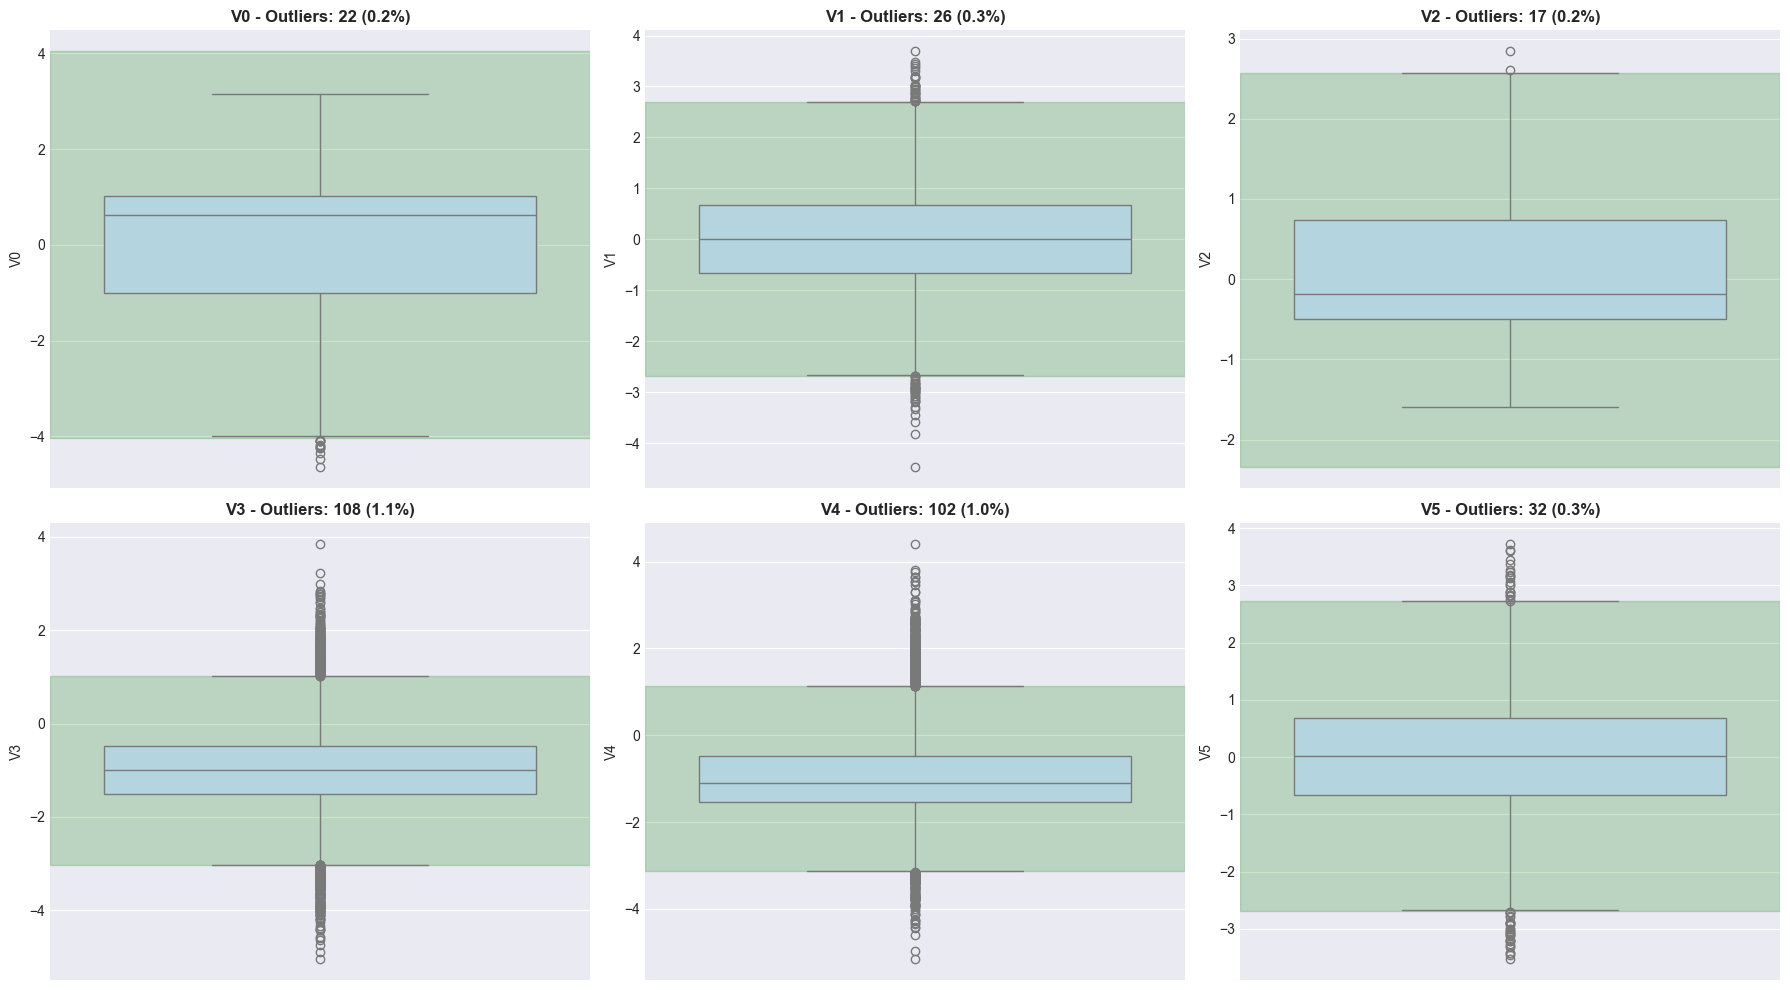


⚠️  WARNING: Outliers detected
   Consider robust scaling or outlier treatment

EDA SUMMARY REPORT
Total Features Analyzed: 11
Imbalance Ratio: 64.359477124183
Fraud Rate: 1.53
Outlier Features: 11
High Correlation Pairs: 2


In [5]:
# Step 2: Exploratory Data Analysis
print("\n" + "="*80)
print("STEP 2: EXPLORATORY DATA ANALYSIS (EDA)")
print("="*80)

# Initialize EDA
eda = FraudEDA(figsize=(12, 8))

# 2.1 Class Distribution Analysis
class_stats = eda.analyze_class_distribution(df_fraud_clean, target_col='Class')

# 2.2 Univariate Analysis
eda.univariate_analysis(df_fraud_clean)

# 2.3 Bivariate Analysis
eda.bivariate_analysis(df_fraud_clean, target_col='Class')

# 2.4 Correlation Analysis
eda.correlation_analysis(df_fraud_clean)

# 2.5 Outlier Analysis
eda.outlier_analysis(df_fraud_clean)

# Generate EDA report
eda_report = eda.generate_eda_report()


STEP 3: GEOLOCATION INTEGRATION
⚠️  'ip_address' missing. Generating synthetic IPs for demonstration.
📥 Loading IP-to-country mapping from ../data/raw/IpAddress_to_Country.csv...
🔄 Converting IP addresses to integers...
✓ IP-to-country mapping loaded: 138,846 ranges
✓ IP range: 16,777,216 to 3,758,096,383

🌍 Top 10 countries by IP range count:
  United States: 46,868 ranges
  Canada: 6,989 ranges
  Russian Federation: 6,739 ranges
  Australia: 6,316 ranges
  Germany: 5,999 ranges
  United Kingdom: 5,401 ranges
  Brazil: 4,885 ranges
  China: 3,725 ranges
  Poland: 3,042 ranges
  Japan: 3,005 ranges
🗺️  Mapping 10,000 IP addresses to countries...
🔄 Converting IPs to integers...
🔍 Performing vectorized IP lookup...
✓ IP mapping completed: 8,233/10,000 mapped (82.33%)

🌍 Top countries in dataset:
  United States: 3,634 IPs (36.3%)
  China: 729 IPs (7.3%)
  Japan: 462 IPs (4.6%)
  Korea Republic of: 298 IPs (3.0%)
  United Kingdom: 290 IPs (2.9%)
  Germany: 221 IPs (2.2%)
  France: 199 IP

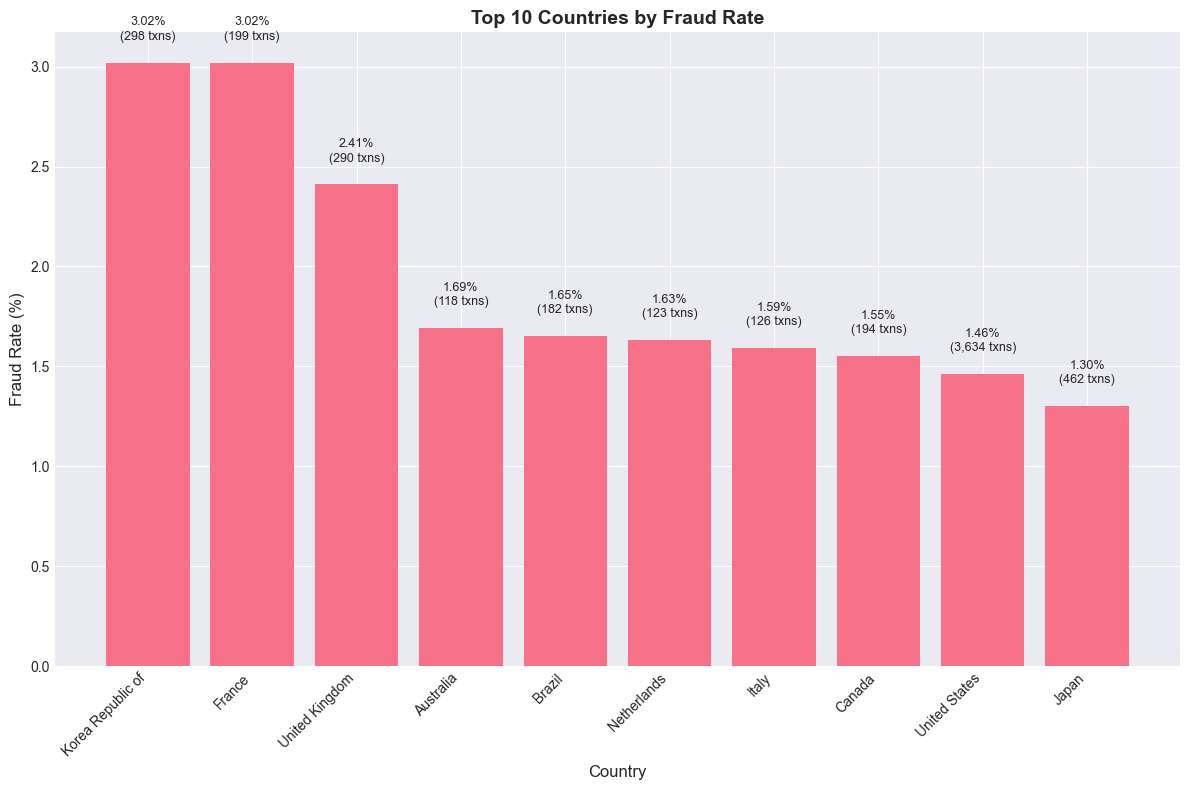


⚠️  HIGH-RISK COUNTRIES (fraud rate > 6.67%):
  Mauritius: 100.00% fraud (1 frauds in 1 transactions)
  Guatemala: 50.00% fraud (1 frauds in 2 transactions)
  Serbia: 25.00% fraud (1 frauds in 4 transactions)
  Morocco: 14.29% fraud (1 frauds in 7 transactions)
  Greece: 10.00% fraud (2 frauds in 20 transactions)
  Hungary: 7.69% fraud (1 frauds in 13 transactions)

IP MAPPING VALIDATION
  8.8.8.8              → United States
  1.1.1.1              → Australia
  5.62.61.252          → United Kingdom
  103.10.197.50        → Hong Kong
  200.58.127.250       → Argentina
  41.77.96.0           → South Africa
  110.34.183.1         → Thailand
  14.63.166.126        → Korea Republic of
  195.154.183.109      → France
  92.38.148.60         → Russian Federation

✓ Validation success rate: 100.0%


{'8.8.8.8': 'United States',
 '1.1.1.1': 'Australia',
 '5.62.61.252': 'United Kingdom',
 '103.10.197.50': 'Hong Kong',
 '200.58.127.250': 'Argentina',
 '41.77.96.0': 'South Africa',
 '110.34.183.1': 'Thailand',
 '14.63.166.126': 'Korea Republic of',
 '195.154.183.109': 'France',
 '92.38.148.60': 'Russian Federation'}

In [8]:
# Step 3: Geolocation Integration (with synthetic IPs for demo)
print("\n" + "="*80)
print("STEP 3: GEOLOCATION INTEGRATION")
print("="*80)

# Add synthetic IP addresses if missing (FOR DEMO ONLY)
if 'ip_address' not in df_fraud_clean.columns:
    print("⚠️  'ip_address' missing. Generating synthetic IPs for demonstration.")
    np.random.seed(42)  # for reproducibility
    df_fraud_clean['ip_address'] = [
        ".".join(str(np.random.randint(0, 256)) for _ in range(4))
        for _ in range(len(df_fraud_clean))
    ]

# Now proceed
geo_mapper = IPGeolocationMapper()
ip_mapping_path = '../data/raw/IpAddress_to_Country.csv'
geo_mapper.load_ip_country_mapping(ip_mapping_path)

df_fraud_geo = df_fraud_clean.copy()
df_fraud_geo['country'] = geo_mapper.map_ips_to_countries(df_fraud_geo['ip_address'])

fraud_by_country = geo_mapper.analyze_fraud_by_country(df_fraud_geo, ip_col='ip_address')
geo_mapper.validate_mapping()


STEP 4: FEATURE ENGINEERING

COMPREHENSIVE FEATURE ENGINEERING PIPELINE
Step 1: Time-based features
Step 2: Frequency & velocity features
Step 3: Aggregate features
Step 4: Interaction features
Step 5: Geolocation features

CREATING TIME-BASED FEATURES
✗ Error creating time-based features: 'purchase_time'

CREATING FREQUENCY & VELOCITY FEATURES
Justification: Fraudsters often make multiple rapid transactions
✗ Error creating frequency features: 'purchase_time'

CREATING AGGREGATE FEATURES
Justification: Behavioral patterns emerge from aggregated statistics
⚠️  No valid group or value columns for aggregation

CREATING INTERACTION FEATURES
Justification: Combined effects can be more predictive than individual features
✓ Created 70 interaction features

🤝 Interaction features created:
  - v0_x_v1
  - v0_div_v1
  - v0_x_v2
  - v0_div_v2
  - v0_x_v3
  - v0_div_v3
  - v0_x_v4
  - v0_div_v4
  - v0_x_v5
  - v0_div_v5
  ... and 60 more

CREATING GEOLOCATION FEATURES
Justification: Fraud patter

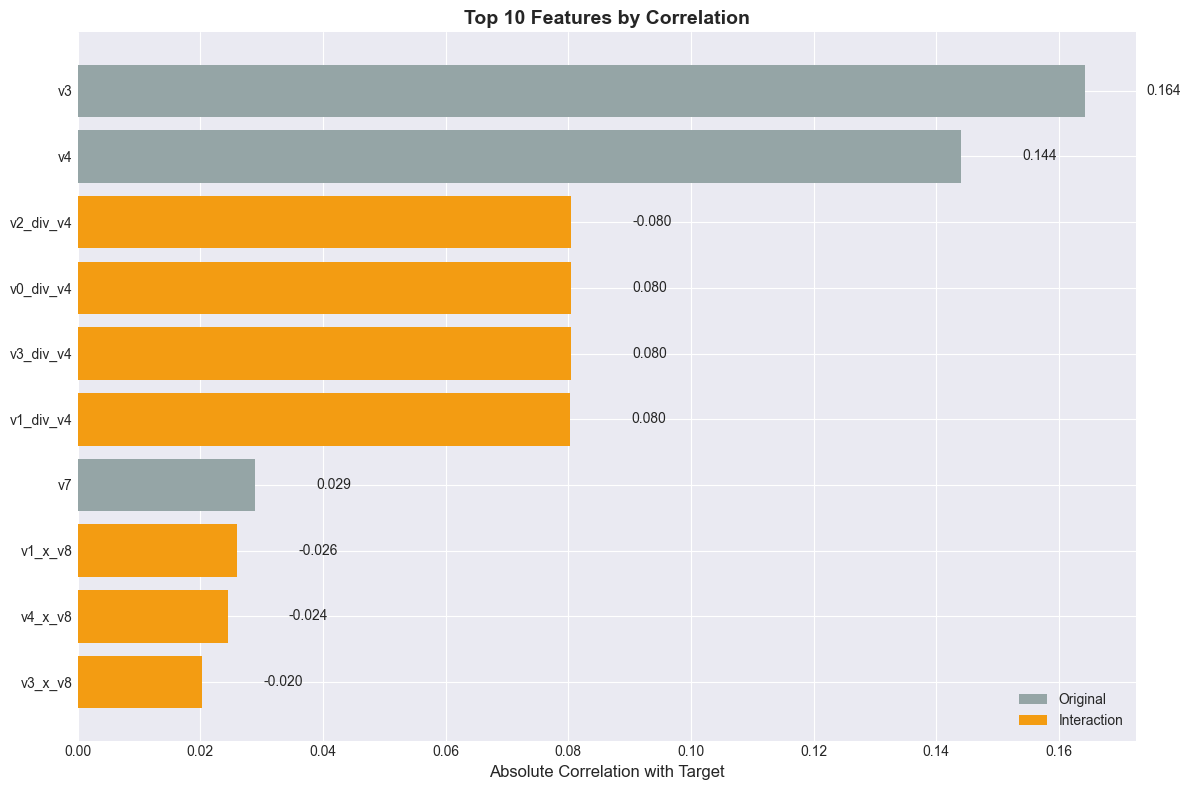


💾 Engineered data saved to: ../data/processed/fraud_data_engineered.csv
   Shape: (10000, 89)


In [9]:
# Step 4: Feature Engineering
print("\n" + "="*80)
print("STEP 4: FEATURE ENGINEERING")
print("="*80)

# Initialize feature engineer
feature_engineer = FraudFeatureEngineer(verbose=True)

# Create all features
df_fraud_features = feature_engineer.create_all_features(df_fraud_geo, target_col='class')

# Display feature statistics
print(f"\n📈 Feature Engineering Statistics:")
print(feature_engineer.feature_stats)

# Analyze feature importance
importance_report = feature_engineer.get_feature_importance_report(
    df_fraud_features, target_col='class', top_n=20
)

# Save engineered data
output_path = '../data/processed/fraud_data_engineered.csv'
df_fraud_features.to_csv(output_path, index=False)
print(f"\n💾 Engineered data saved to: {output_path}")
print(f"   Shape: {df_fraud_features.shape}")

In [10]:
# Step 5: Data Transformation
print("\n" + "="*80)
print("STEP 5: DATA TRANSFORMATION")
print("="*80)

# Initialize transformer
transformer = FraudDataTransformer(random_state=42, verbose=True)

# Run complete transformation pipeline
transformed_data = transformer.full_pipeline(
    df=df_fraud_features,
    target_col='class',
    normalize_method='standard',
    encode_method='label',
    imbalance_method='smote',
    test_size=0.2
)

# Display transformation results
X_train = transformed_data['X_train']
X_test = transformed_data['X_test']
y_train = transformed_data['y_train']
y_test = transformed_data['y_test']

print(f"\n✅ Transformation Complete:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train fraud rate: {y_train.mean():.4f}")
print(f"y_test fraud rate: {y_test.mean():.4f}")

# Save transformed data
train_output = '../data/processed/X_train.csv'
test_output = '../data/processed/X_test.csv'
pd.DataFrame(X_train).to_csv(train_output, index=False)
pd.DataFrame(X_test).to_csv(test_output, index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

print(f"\n💾 Transformed data saved to data/processed/")


STEP 5: DATA TRANSFORMATION

COMPLETE DATA TRANSFORMATION PIPELINE
Step 1: Train-test split (stratified)
Step 2: Categorical feature encoding
Step 3: Numerical feature normalization
Step 4: Class imbalance handling (training set only)

STRATIFIED TRAIN-TEST SPLIT
Justification: Preserve class distribution in both sets
Total samples: 10,000
Features: 88
Class distribution:
  Class 0: 98.47% (9,847 samples)
  Class 1: 1.53% (153 samples)

✓ Split completed:
  Training set: 8,000 samples
  Test set: 2,000 samples
  Train fraud rate: 1.5250%
  Test fraud rate: 1.5500%

✅ Stratification verified:
  Original fraud rate: 1.5300%
  Train fraud rate: 1.5250%
  Test fraud rate: 1.5500%

ENCODING CATEGORICAL FEATURES (LABEL)
Justification: Convert categorical data to numerical format for ML algorithms
Found 2 categorical columns:
  ip_address: 8000 unique values
  country: 114 unique values

🔤 Applying Label Encoding...
✓ Applied label encoding to 2 columns

✅ Encoding completed
  Total features